In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
event_seq_NL= "../../data_brute/event sequencage - pedagogie emergente.csv"
info_NL= "../../data_brute/informations - pedagogie emergente.csv"
tracking_NL= "../../data_brute/tracking GPS - pedagogie emergente.csv"

df_events= pd.read_csv(event_seq_NL, sep=";")
df_infos = pd.read_csv(info_NL, sep=";")
df_tracking = pd.read_csv(tracking_NL)

C:\Users\Ousmane Kontao\AppData\Local\Temp\ipykernel_49880\2199026724.py:7: DtypeWarning: Columns (2,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tracking = pd.read_csv(tracking_NL)


#### 1) df_infos

In [3]:
print(f"Le dataframe avec les informations sur le GPS et l'Id du joueur: \n {df_infos[:]}")
print()
df_infos.info()
print()

Le dataframe avec les informations sur le GPS et l'Id du joueur: 
    Team  GPS  ID
0   Att    8   2
1   Att    9   4
2   Att    2   5
3   Att    3   6
4   Att   15   1
5   Att   24   3
6   Def    4  11
7   Def    6  15
8   Def   13  13
9   Def   19  12
10  Def   16  16
11  Def   18  14

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Team    12 non-null     object
 1   GPS     12 non-null     int64 
 2   ID      12 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 420.0+ bytes



Nous avons une équipe d'attaque de 6 joueurs et une équipe de défense de 6 joueurs également identifié par leur numero de boite GPS et leur id 

Que faire avec ces infos ? 

In [4]:
gps_to_id = dict(zip(df_infos['GPS'], df_infos['ID']))
id_to_team = dict(zip(df_infos["ID"], df_infos["Team"]))
print(f"Nous allons utiliser ce dictionnaire pour faire la correspondance entre le numéro de GPS et l'id du joueur:\n{gps_to_id} ")
print()
print(f"Id vers équipe pour savoir si c'eest l'attaque ou la defense:\n{id_to_team}")

Nous allons utiliser ce dictionnaire pour faire la correspondance entre le numéro de GPS et l'id du joueur:
{8: 2, 9: 4, 2: 5, 3: 6, 15: 1, 24: 3, 4: 11, 6: 15, 13: 13, 19: 12, 16: 16, 18: 14} 

Id vers équipe pour savoir si c'eest l'attaque ou la defense:
{2: 'Att', 4: 'Att', 5: 'Att', 6: 'Att', 1: 'Att', 3: 'Att', 11: 'Def', 15: 'Def', 13: 'Def', 12: 'Def', 16: 'Def', 14: 'Def'}


In [5]:
df_infos[df_infos["GPS"] == 12]

,Team,GPS,ID


In [6]:
df_infos[df_infos["GPS"] == 8]

,Team,GPS,ID
0,Att,8,2


Cela nous permettra de relier les données tracking aux évenements

#### 2) df_tracking

In [7]:
df_tracking = df_tracking.drop(columns="Unnamed: 0", axis=1)
df_tracking.dropna(subset=["Player"])
#df_tracking = df_tracking[(df_tracking["Player"] != "Ball") & (df_tracking["ID"] != "Ball")]
df_tracking["Player"] = df_tracking["Player"].fillna(0).astype(int)

In [8]:
# trier le dataframe par la colonne "Time"
df_tracking = df_tracking.sort_values(by="Time")

In [9]:
df_tracking.dtypes

Possession      int64
GPS            object
Time          float64
X             float64
Y             float64
Team           object
Player          int64
Frame         float64
Position      float64
ID             object
dtype: object

J'ai viré tous les lignes avec la ball dans la colonne Player car mon graphe ou mes animations peuvent croire que le ballon est un joueur... ce qui rendrait toutes les analyses fausses !

In [10]:
print(df_tracking['Time'].unique()[:12])  # affiche les 5 premiers temps possibles

[0.24 0.26 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46]


In [12]:
df_tracking

,Possession,GPS,Time,X,Y,Team,Player,Frame,Position,ID
8877,1,39,0.24,-4.321469,-12.797195,Att,4,2.0,240.0,4
807,1,16,0.24,6.358118,0.288140,Def,12,2.0,240.0,4
7263,1,34,0.24,9.066144,2.018168,Def,17,2.0,240.0,2
3228,1,27,0.24,4.762210,2.083775,Att,1,2.0,240.0,1
2421,1,26,0.24,-6.066594,-25.392708,Att,6,2.0,240.0,6
...,...,...,...,...,...,...,...,...,...,...
203083,43,31,2178.84,32.663899,30.709211,Def,15,21788.0,2178840.0,6
203476,43,32,2178.84,30.737538,30.511595,Def,14,21788.0,2178840.0,7
204655,43,39,2178.84,35.801745,26.564518,Att,4,21788.0,2178840.0,4
202690,43,30,2178.84,15.909712,29.503231,Def,11,21788.0,2178840.0,3


In [13]:
df_ball = df_tracking[(df_tracking["GPS"] == "Ball")]# & (df_tracking["Player"] == 2)]
df_ball

,Possession,GPS,Time,X,Y,Team,Player,Frame,Position,ID
205049,1,Ball,0.24,-0.246097,-3.833314,Att,2,2.0,240.0,Ball
205050,1,Ball,0.26,-0.329845,-4.078137,NaN,0,NaN,260.0,Ball
205051,1,Ball,0.28,-0.413593,-4.322960,NaN,0,NaN,280.0,Ball
205052,1,Ball,0.30,-0.497341,-4.567783,NaN,0,NaN,300.0,Ball
205053,1,Ball,0.32,-0.581089,-4.812606,NaN,0,NaN,320.0,Ball
...,...,...,...,...,...,...,...,...,...,...
220817,43,Ball,2178.76,36.115058,23.408468,Att,2,21787.0,2178760.0,Ball
220818,43,Ball,2178.78,36.213258,23.401453,Att,2,21787.0,2178780.0,Ball
220819,43,Ball,2178.80,36.311458,23.394437,Att,2,21788.0,2178800.0,Ball
220820,43,Ball,2178.82,36.408081,23.422931,Att,2,21788.0,2178820.0,Ball


#### 3) df_events

In [14]:
df_events.head()

,Position,Possession,Condition,Serie,Defense,Cote,Passeur,Receveur,Contact,Pied,Resultat
0,37320,1,EMERGENT,PRE,OUVERT,GAUCHE,1.0,NaN,NaN,NaN,NaN
1,37960,1,EMERGENT,PRE,OUVERT,GAUCHE,NaN,2.0,NaN,NaN,NaN
2,39000,1,EMERGENT,PRE,OUVERT,GAUCHE,2.0,NaN,NaN,NaN,NaN
3,39760,1,EMERGENT,PRE,OUVERT,GAUCHE,NaN,5.0,NaN,NaN,NaN
4,41600,1,EMERGENT,PRE,OUVERT,GAUCHE,5.0,NaN,contact,NaN,NaN


In [32]:
df_events.columns = [col.strip() for col in df_events.columns]

total_possessions = df_events['Possession'].nunique()
total_passes = df_events['Passeur'].notna().sum()
total_receptions = df_events['Receveur'].notna().sum()
total_fins = df_events['Resultat'].notna().sum()
passes_contact = df_events['Contact'].str.lower().eq('contact').sum()
passes_pied = df_events['Pied'].notna().sum()
passes_diagonale = df_events['Pied'].notna().eq('diag').sum()

In [33]:
stats = {
    "Nombre total de possessions": total_possessions,
    "Nombre total de passes": total_passes,
    "Nombre total de réceptions": total_receptions,
    "Nombre total de fins de possession": total_fins,
    "Passes après contact": passes_contact,
    "Passes au pied": passes_pied,
    "Passes diagonales": passes_diagonale
}

stats

{'Nombre total de possessions': 44,
 'Nombre total de passes': np.int64(153),
 'Nombre total de réceptions': np.int64(0),
 'Nombre total de fins de possession': np.int64(0),
 'Passes après contact': np.int64(44),
 'Passes au pied': np.int64(6),
 'Passes diagonales': np.int64(0)}

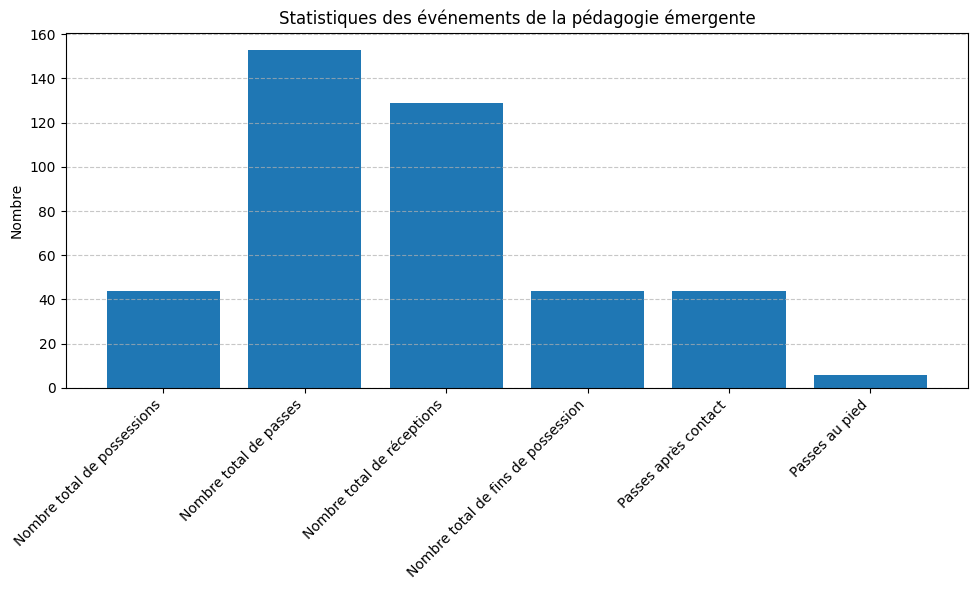

In [17]:
labels = list(stats.keys())
values = list(stats.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, values)
plt.title("Statistiques des événements de la pédagogie émergente")
plt.ylabel("Nombre")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [18]:
df_events['Time_s'] = df_events['Position'] / 1000
df_events = df_events.sort_values(by='Time_s')

C'est important de mettre le time parce que position contient le timecode des evenements en ms donc en le divisant par 1000 on peut synchroniser un événement avec le bon moment du tracking

In [19]:
df_events["Passeur"] = pd.to_numeric(df_events["Passeur"],  errors='coerce')
df_events['Receveur'] = pd.to_numeric(df_events["Receveur"], errors='coerce')

#### 4) Synchronisation des evenements et des trackings pour pourvoir visualiser une passe

In [20]:
print(df_tracking.head(5))
print()
print(f"La dernière frame est {df_tracking.loc[len(df_tracking)-1, "Frame"]}")

      Possession GPS  Time         X          Y Team  Player  Frame  Position  \
8877           1  39  0.24 -4.321469 -12.797195  Att       4    2.0     240.0   
807            1  16  0.24  6.358118   0.288140  Def      12    2.0     240.0   
7263           1  34  0.24  9.066144   2.018168  Def      17    2.0     240.0   
3228           1  27  0.24  4.762210   2.083775  Att       1    2.0     240.0   
2421           1  26  0.24 -6.066594 -25.392708  Att       6    2.0     240.0   

     ID  
8877  4  
807   4  
7263  2  
3228  1  
2421  6  

La dernière frame est 21788.0


In [21]:
print(df_events.head(5))

   Position  Possession Condition Serie Defense    Cote  Passeur  Receveur  \
0     37320           1  EMERGENT   PRE  OUVERT  GAUCHE      1.0       NaN   
1     37960           1  EMERGENT   PRE  OUVERT  GAUCHE      NaN       2.0   
2     39000           1  EMERGENT   PRE  OUVERT  GAUCHE      2.0       NaN   
3     39760           1  EMERGENT   PRE  OUVERT  GAUCHE      NaN       5.0   
4     41600           1  EMERGENT   PRE  OUVERT  GAUCHE      5.0       NaN   

   Contact Pied Resultat  Time_s  
0      NaN  NaN      NaN   37.32  
1      NaN  NaN      NaN   37.96  
2      NaN  NaN      NaN   39.00  
3      NaN  NaN      NaN   39.76  
4  contact  NaN      NaN   41.60  


In [22]:
df_tracking.loc[df_tracking['Player'] == 1]["Time"][3228:]

37235      361.96
37236      361.98
37237      362.00
37238      362.02
37239      362.04
           ...   
201900    2178.76
201901    2178.78
201902    2178.80
201903    2178.82
201904    2178.84
Name: Time, Length: 15694, dtype: float64

In [23]:
df_tracking = df_tracking[df_tracking['Frame'].notna()]

In [24]:
df_events["Time_s"] = df_events["Time_s"].astype(int)
df_tracking["Time"] = df_tracking["Time"].astype(int)

C:\Users\Ousmane Kontao\AppData\Local\Temp\ipykernel_49880\2872103671.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tracking["Time"] = df_tracking["Time"].astype(int)


In [25]:
df_events = df_events.dropna(subset=["Passeur"])


In [26]:
df_events

,Position,Possession,Condition,Serie,Defense,Cote,Passeur,Receveur,Contact,Pied,Resultat,Time_s
0,37320,1,EMERGENT,PRE,OUVERT,GAUCHE,1.0,NaN,NaN,NaN,NaN,37
2,39000,1,EMERGENT,PRE,OUVERT,GAUCHE,2.0,NaN,NaN,NaN,NaN,39
4,41600,1,EMERGENT,PRE,OUVERT,GAUCHE,5.0,NaN,contact,NaN,NaN,41
7,77520,2,EMERGENT,PRE,SERRE,GAUCHE,3.0,NaN,NaN,NaN,NaN,77
9,78840,2,EMERGENT,PRE,SERRE,GAUCHE,2.0,NaN,NaN,diag,NaN,78
...,...,...,...,...,...,...,...,...,...,...,...,...
315,1772160,43,EMERGENT,POST,SERRE,DROITE,3.0,NaN,NaN,NaN,NaN,1772
317,1773760,43,EMERGENT,POST,SERRE,DROITE,1.0,NaN,NaN,NaN,NaN,1773
319,1777440,43,EMERGENT,POST,SERRE,DROITE,2.0,NaN,NaN,NaN,NaN,1777
321,1810280,44,EMERGENT,POST,SERRE,DROITE,1.0,NaN,NaN,NaN,NaN,1810


In [37]:
df_events[df_events["Pied"] == "diag"]

,Position,Possession,Condition,Serie,Defense,Cote,Passeur,Receveur,Contact,Pied,Resultat,Time_s
9,78840,2,EMERGENT,PRE,SERRE,GAUCHE,2.0,NaN,NaN,diag,NaN,78
